In [3]:
from simulator import Sim, update_best_positions
from strategy import StoikovStrategy
from get_info import get_pnl
from load_data import load_md_from_file


import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

PATH_TO_FILE = '../data/'
NROWS = 500_000

In [4]:
md = load_md_from_file(path=PATH_TO_FILE, nrows=NROWS)

In [5]:
latency = pd.Timedelta(10, 'ms').delta
md_latency = pd.Timedelta(10, 'ms').delta

sim = Sim(md, latency, md_latency)

C:\Users\alpat\AppData\Local\Temp\ipykernel_1180\3629183269.py:1: FutureWarning: Timedelta.delta is deprecated and will be removed in a future version.
  latency = pd.Timedelta(10, 'ms').delta
C:\Users\alpat\AppData\Local\Temp\ipykernel_1180\3629183269.py:2: FutureWarning: Timedelta.delta is deprecated and will be removed in a future version.
  md_latency = pd.Timedelta(10, 'ms').delta


Here we calculate mid-prices to estimate volatility for the whole period of time of our data

In [6]:
mid_price_arr  = []
best_bid, best_ask = None, None
for update in md:
    best_bid, best_ask = update_best_positions(best_bid, best_ask, update)
    if update.trade is not None:
        if update.trade.side == 'BID':
            best_ask = update.trade.price
        elif update.trade.side == 'ASK':
            best_bid = update.trade.price
    if best_bid is not None:
        mid_price_arr.append(0.5*(best_bid + best_ask))

mid_price_arr = np.array(mid_price_arr)

In [7]:
profits = mid_price_arr[1:] - mid_price_arr[:-1]
sigma = np.std(profits)

In [8]:
print(sigma)

0.47186525283351466


In [9]:
# we take risk-aversity as in Stoikov paper
gamma = 0.1
# we take k value equal to 1 (in the meeting this value was said to be the most adequate for our data)
k = 1

In [10]:
#delay between orders
delay = pd.Timedelta(0.01, 's').delta
#hold_time
hold_time = pd.Timedelta(10, 's').delta
# start time
t_start = md[0].receive_ts
# end time T
t_end = md[-1].receive_ts
strategy = StoikovStrategy(delay, hold_time, t_start, t_end, sigma, gamma, k)

C:\Users\alpat\AppData\Local\Temp\ipykernel_1180\1505070097.py:2: FutureWarning: Timedelta.delta is deprecated and will be removed in a future version.
  delay = pd.Timedelta(0.01, 's').delta
C:\Users\alpat\AppData\Local\Temp\ipykernel_1180\1505070097.py:4: FutureWarning: Timedelta.delta is deprecated and will be removed in a future version.
  hold_time = pd.Timedelta(10, 's').delta


In [11]:
trades_list, md_list, updates_list, all_orders = strategy.run(sim)

In [12]:
pnl = get_pnl(updates_list)
pnl.receive_ts = pd.to_datetime(pnl.receive_ts)
pnl.exchange_ts = pd.to_datetime(pnl.exchange_ts)
pnl = pnl.iloc[::100, :].reset_index().drop(columns=['index'])

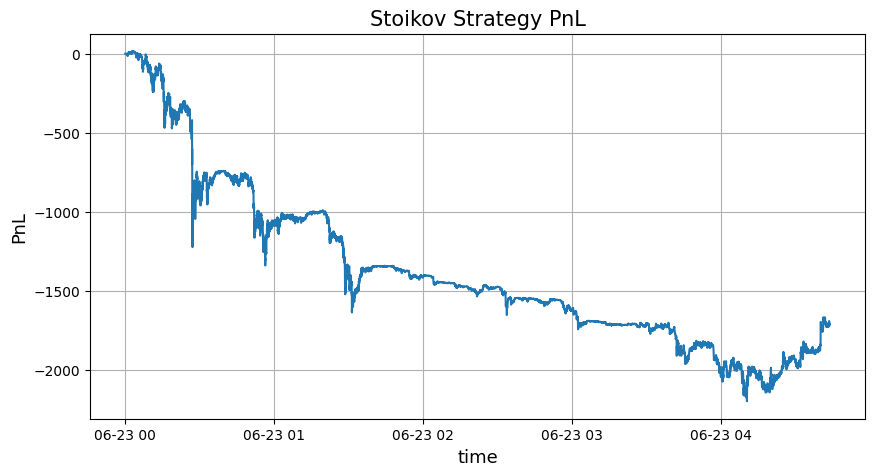

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(pnl.receive_ts, pnl.total, '-')
plt.xlabel("time", fontsize=13)
plt.ylabel("PnL", fontsize=13)
plt.title("Stoikov Strategy PnL", fontsize=15)
plt.grid()
plt.show()